In [1]:
# CNN on the classic CIFAR dataset
# sources
# https://www.cs.toronto.edu/~kriz/cifar.html
# https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

# You can run this notebook on CPU if the GPU is not available
# Updated March 6, 2024.

import os, sys
import torch, torchvision
import torchvision.transforms as transforms
import numpy
import matplotlib.pyplot as plt

In [2]:
import os, sys
import urllib.request

from google.colab import drive
drive.mount('/content/drive')
#change this based on your setup
root = '/content/drive/MyDrive/ART/machinelearning/'
sys.path.append(root +'code/')
datapath =  root + 'data/'
resultspath = root + 'results/'

Mounted at /content/drive


In [3]:
# Load the training and testing data and normalize the images
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root=datapath, train=True,download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root=datapath, train=False,download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [4]:
def imshow(img):
    img = img / 2 + 0.5               # unnormalize
    npimg = img.numpy()
    plt.imshow(numpy.transpose(npimg, (1, 2, 0)))
    plt.show()

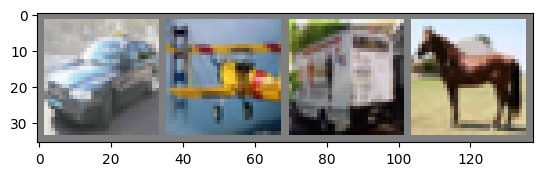

car   plane truck horse


In [5]:
# Get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)
#images, labels = dataiter.next()

# Show some training images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))


In [13]:
import torch.nn as nn
import torch.nn.functional as F

# Define a generic Convolutional Neural Net (CNN) model
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()
total_params = sum(p.numel() for p in net.parameters())
print(f"Number of parameters: {total_params}")

Number of parameters: 62006


In [7]:
# Set the loss function (criterion) and the optimizer
# https://pytorch.org/docs/stable/optim.html
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [18]:
# Train and test the network
num_epochs = 8
for epoch in range(num_epochs):        # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished training the network with the chosen number of epochs')

[1,  2000] loss: 0.852
[1,  4000] loss: 0.870
[1,  6000] loss: 0.875
[1,  8000] loss: 0.862
[1, 10000] loss: 0.847
[1, 12000] loss: 0.884
[2,  2000] loss: 0.854
[2,  4000] loss: 0.859
[2,  6000] loss: 0.848
[2,  8000] loss: 0.869
[2, 10000] loss: 0.881
[2, 12000] loss: 0.863
[3,  2000] loss: 0.855
[3,  4000] loss: 0.854
[3,  6000] loss: 0.846
[3,  8000] loss: 0.866
[3, 10000] loss: 0.876
[3, 12000] loss: 0.877
[4,  2000] loss: 0.874
[4,  4000] loss: 0.856
[4,  6000] loss: 0.869
[4,  8000] loss: 0.867
[4, 10000] loss: 0.855
[4, 12000] loss: 0.853
[5,  2000] loss: 0.841
[5,  4000] loss: 0.861
[5,  6000] loss: 0.870
[5,  8000] loss: 0.870
[5, 10000] loss: 0.875
[5, 12000] loss: 0.865
[6,  2000] loss: 0.861
[6,  4000] loss: 0.866
[6,  6000] loss: 0.855
[6,  8000] loss: 0.870
[6, 10000] loss: 0.853
[6, 12000] loss: 0.880
[7,  2000] loss: 0.864
[7,  4000] loss: 0.882
[7,  6000] loss: 0.854
[7,  8000] loss: 0.866
[7, 10000] loss: 0.847
[7, 12000] loss: 0.861
[8,  2000] loss: 0.872
[8,  4000] 

In [19]:
# Save the model
modelname = 'cifar_net_' + str(num_epochs) + '_epochs.pth'
torch.save(net.state_dict(), datapath + modelname)

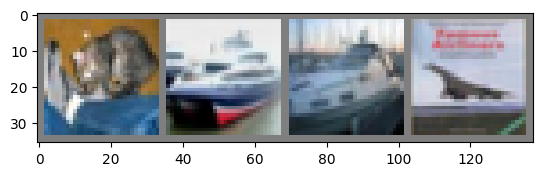

GroundTruth:  cat   ship  ship  plane


In [14]:
# Check some of the test images
dataiter = iter(testloader)
images, labels = next(dataiter)
#images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [20]:
# Load the model again
net = Net()
modelname = 'cifar_net_' + str(num_epochs) + '_epochs.pth'
net.load_state_dict(torch.load(datapath + modelname))

<All keys matched successfully>

In [21]:
# Get the predictions from the model
outputs = net(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'for j in range(4)))

Predicted:  frog  dog   car   horse


In [22]:
# Find the accuracy of the model on all classes

correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients across all categories
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 61 %


In [23]:
# Find the accuracy of predictions for each of the categories
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')


Accuracy for class: plane is 73.1 %
Accuracy for class: car   is 79.1 %
Accuracy for class: bird  is 58.7 %
Accuracy for class: cat   is 46.9 %
Accuracy for class: deer  is 39.6 %
Accuracy for class: dog   is 41.9 %
Accuracy for class: frog  is 71.4 %
Accuracy for class: horse is 64.8 %
Accuracy for class: ship  is 73.8 %
Accuracy for class: truck is 70.1 %


#optional - operate on GPU instead of CPU
```
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net.to(device)
inputs, labels = data[0].to(device), data[1].to(device)
```


